In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from hw2 import get_mnist_threes_nines, display_image
%matplotlib inline

1.1

(12080, 28, 28) (12080,)


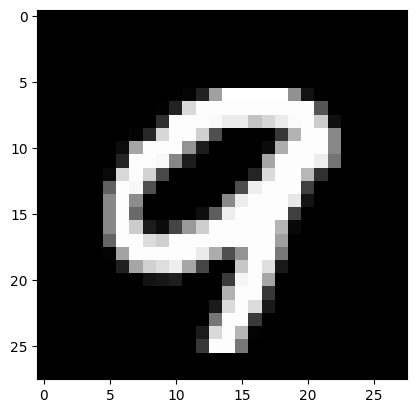

In [22]:
train, test = get_mnist_threes_nines()
X_train, y_train = train
X_test, y_test = test

print(X_train.shape, y_train.shape)
rand = np.random.randint(low=0, high=X_train.shape[0])
display_image(X_train[rand])


1.2a (finite differences checker, used to help implement `my_nn_finite_difference_checker` in 1.3a. Feel free to modify the function signature, or to skip this part and implement `my_nn_finite_difference_checker` without this helper function.)

In [23]:
def finite_difference_checker(f, x, k):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    epsilon = 10**-5
    epsilon_vector = np.zeros(x.shape)
    epsilon_vector[k] = epsilon
    derivative = (f(x + epsilon_vector)[0] - f(x - epsilon_vector)[0])/2*epsilon
    return derivative

1.2b (functions that implement neural network layers)

In [24]:
def sigmoid(s):

    epsilon = 10**-15

    if s<0:
        return np.clip(np.exp(s)/(1+np.exp(s)), epsilon, 1-epsilon)
    else:
        return np.clip(1/(1+np.exp(-s)), epsilon, 1-epsilon)

def sigmoid_derivative(s):
    return sigmoid(s)*(1-sigmoid(s))

def sigmoid_activation(x):

    sigmoid_vectorized = np.vectorize(sigmoid)
    out = sigmoid_vectorized(x)

    sigmoid_derivative_vectorized = np.vectorize(sigmoid_derivative)
    grad = sigmoid_derivative_vectorized(x)
    assert grad.shape == x.shape
    assert out.shape == x.shape
    return out, grad

def logistic_loss(g, y):
    """
    Computes the loss and gradient for binary classification with logistic
    loss

    Inputs:
    - g: Output of final layer with sigmoid activation,
         of shape (n, 1)

    - y: Vector of labels, of shape (n,) where y[i] is the label for x[i]
         and y[i] in {0, 1}

    Returns a tuple of:
    - loss: array of losses
    - dL_dg: Gradient of the loss with respect to g
    """
    loss = -(y*np.log(g)+(1-y)*np.log(1-g))
    dL_dg = (g-y)/(g-g**2)
    return loss, dL_dg

def relu(s):
    return max(0,s)

def relu_derivative(s):
    return int(s>0)

def relu_activation(s):
    relu_vectorized = np.vectorize(relu)
    out = relu_vectorized(s)

    relu_derivative_vectorized = np.vectorize(relu_derivative)
    ds = relu_derivative_vectorized(s)
    assert ds.shape == s.shape
    assert out.shape == s.shape
    return out, ds

def layer_forward(x, W, b, activation_fn):
    bias = np.repeat(b, x.shape[0], axis = 0)
    S_l = (x @ W) + bias
    out, gradient = activation_fn(S_l)


    #Need delta_j at layer l, weights at layer l and the derivative
    #of activation function at S_i at layer l-1
    cache = np.array([out, gradient, W])

    return out, cache


1.3b i, ii (deliverables for the sigmoid activation)

In [25]:
# 1.3b i
s = np.asarray([1., 0., -1])
out, grad = sigmoid_activation(s)
with np.printoptions(precision=2):
    print(out)
    print(grad)
    
print("="*80)

# 1.3b ii
s = np.asarray([-1000., 1000.])
out, grad = sigmoid_activation(s)
print(out)
print(grad)

[0.73 0.5  0.27]
[0.2  0.25 0.2 ]
[1.e-15 1.e+00]
[1.00000000e-15 9.99200722e-16]


1.3 ii
We'll get an error if the exp() function takes in a too negative number. I therefore switch between two different equations (but yielding same number) for the sigmoid to avoid having exp() of a large number.

1.3b iii: What is the derivative of the negative log-likelihood loss with respect to $g$?

The derivative is $\frac{g-y}{g-g^2}$.

1.3b iv: Explain what is returned in `cache` in your `layer_forward` implementation. (Trying to answer this question before completing your implementation might help think about should go in `cache`, which should be stuff computed during the forward pass that is needed for backpropagation in the backward pass. Just make sure your final answer pertains to what you ultimately return in `cache`.)


- Output of the layer to use when calculating $\frac{\partial L}{\partial w_{ij}}$ using $\delta_j$
- The gradient of the output given $S_l$ used when calculating $delta_j$
- The weights from layer i to j, used to calculate $delta_j$


1.2c (in this part you will code functions that initialize the neural network's weights. You will also code the forward pass which ties everything together, computing the output of a neural network with weights given by `weight_matrices` + `biases`, activation functions given by `activations`, on the input `X_batch`, a 2d input where each row is an individual input vector)

In [26]:
def create_weight_matrices(layer_dims):
    """
    Creates a list of weight matrices defining the weights of NN
    
    Inputs:
    - layer_dims: A list whose size is the number of layers. layer_dims[i] defines
      the number of neurons in the i+1 layer.

    Returns a list of weight matrices
    """
    weights = []
    for i in range(len(layer_dims)-1):
        weights.append(np.full((layer_dims[i], layer_dims[i+1]), np.random.normal(loc=0.0, scale= 0.01, size = (layer_dims[i], layer_dims[i+1]))))
    return weights

def create_bias_vectors(layer_dims):
    biases = []
    for i in range(len(layer_dims)-1):
        biases.append(np.full((1, layer_dims[i+1]), np.random.normal(loc=0.0, scale = 0.01, size = (1, layer_dims[i+1]))))
    return biases

def forward_pass(X_batch, weight_matrices, biases, activations):
    layer_caches = [[X_batch]]
    outs = []
    output = X_batch
    for i in range(len(weight_matrices)):
        output, cache = layer_forward(output, weight_matrices[i], biases[i], activations[i])
        outs.append(output)
        layer_caches.append(cache)

    output = outs[-1]
    return output, layer_caches

1.3c (deliverable which has you run a forward pass of your neural network and compute its logistic loss on some output)

In [27]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases,
                         activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985204992027605


C:\Users\elias\AppData\Local\Temp\ipykernel_26764\2568116894.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cache = np.array([out, gradient, W])


1.3a (deliverable which has you compute the gradient w.r.t. `weight_matrices` and `biases` using a finite differences checker)

In [28]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

def my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations):
    output =  forward_pass(X_batch, weight_matrices, biases, activations)[0]

    epsilon = 1E-5
    grad_Ws = []
    grad_bs = []

    for layer_index in range(len(weight_matrices)):
        layer_weight_difs = np.zeros(weight_matrices[layer_index].shape)
        layer_bias_difs = []

        for c in range(len(weight_matrices[layer_index])):
            for r in range(len(weight_matrices[layer_index][c])):
                weight_matrices[layer_index][c, r] += epsilon
                large = logistic_loss(forward_pass(X_batch, weight_matrices, biases, activations)[0], y_batch)[0]

                weight_matrices[layer_index][c, r] -= 2*epsilon
                small = logistic_loss(forward_pass(X_batch, weight_matrices, biases, activations)[0], y_batch)[0]

                weight_matrices[layer_index][c, r] += epsilon

                dif = np.average((large - small) / (2*epsilon))
                layer_weight_difs[c, r] = dif

        for bias_index in range(len(biases[layer_index][0])):
            biases[layer_index][0][bias_index] -= epsilon
            small = logistic_loss(forward_pass(X_batch, weight_matrices, biases, activations)[0], y_batch)[0]

            biases[layer_index][0][bias_index] += 2*epsilon
            large = logistic_loss(forward_pass(X_batch, weight_matrices, biases, activations)[0], y_batch)[0]

            biases[layer_index][0][bias_index] -= epsilon

            dif = np.average((large - small) / (2*epsilon))
            layer_bias_difs.append(dif)

        grad_Ws.append(layer_weight_difs)
        grad_bs.append(layer_bias_difs)

    return grad_Ws, grad_bs

grad_Ws, grad_bs = my_nn_finite_difference_checker(X_batch, y_batch, weight_matrices, biases, activations)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]

[[0.]
 [0.]]

[0.0, 0.0]

[-0.5026794540896606]


C:\Users\elias\AppData\Local\Temp\ipykernel_26764\2568116894.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cache = np.array([out, gradient, W])


1.2d (the backward pass!!!!)

In [29]:
def backward_pass(dL_dg, layer_caches):
    grad_Ws = []
    grad_bs = []

    nr_of_layers = len(layer_caches)
    deltas = [None] * nr_of_layers

    dgds_L = np.array(layer_caches[-1][1]).flatten()
    delta_L = np.reshape(dL_dg * dgds_L, (-1, 1))

    deltas[-1] = delta_L

    #Compute delta s^l for other layers
    for l in reversed(range(1, nr_of_layers - 1)):
        out, dg_dsLm1, _ = layer_caches[l]
        W = layer_caches[l + 1][2]

        # Compute delta for layer below
        delta_L = deltas[l + 1]
        delta_l = dg_dsLm1  * (delta_L@W.T)
        deltas[l] = delta_l


    #grad Ws
    for l in range(nr_of_layers - 1):
        out = layer_caches[l][0]
        out_mat = np.average(out, axis=0).reshape((-1, 1))
        delta_mat = np.average(deltas[l + 1], axis=0).reshape((1, -1))
        dl_dW = out_mat @ delta_mat
        grad_Ws.append(dl_dW)

    #grad bs
    for delta in deltas:
        if delta is not None:
            grad_bs.append(np.average(delta, axis=0))

    return grad_Ws, grad_bs

1.3d (test your backward pass! compare it with 1.3a, the gradient computed by the finite difference checker. The answers should match!)

In [30]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases,
                                    activations)
loss, dL_dg = logistic_loss(output, y_batch)
grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

grad_Ws_fd, grad_bs_fd = my_nn_finite_difference_checker(X_batch,
                                                   y_batch,
                                                   weight_matrices,
                                                   biases,
                                                   activations)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print(grad_Ws_fd[0])
    print()
    print(grad_Ws[1])
    print(grad_Ws_fd[1])
    print()
    print(grad_bs[0])
    print(grad_bs_fd[0])
    print()
    print(grad_bs[1])
    print(grad_bs_fd[1])

C:\Users\elias\AppData\Local\Temp\ipykernel_26764\2568116894.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cache = np.array([out, gradient, W])


ValueError: operands could not be broadcast together with shapes (2,2) (4,2) 

1.2e (train your neural network on MNIST! save the training and test losses and accuracies at each iteration to use in 1.3e)

In [31]:
(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
layer_dims = [784, 200, 1]
activations = [relu_activation, sigmoid_activation]
weights = create_weight_matrices(layer_dims)
biases = create_bias_vectors([200, 1])

1.3e code answers for i, ii, iii

In [ ]:
# i
# Plot the train and test losses from the MNIST network with step size = 0.1
# YOUR CODE HERE

# ii
# Plot the train and test accuracies from the MNIST network with step size = 0.1
# YOUR CODE HERE

# iii
# Visualize (plot) some images that are misclassified by your network

1.3e iii:
Examine the images that your network guesses incorrectly, and explain at a high level
what patterns you see in those images.

**your answer here**

1.3e iv:
Rerun the neural network training but now increase the step size to 10.0. What happens?
You do not need to include plots here.

**your answer here**

1.3f (optional) (Train a network to fit 100 random images to the first 100 original labels! How fast can you memorize the dataset?)

In [ ]:
X_train = np.random.rand(100, 784)
# YOUR CODE HERE